<a href="https://colab.research.google.com/github/Niccolo-Rocchi/Stars_Spectral_Analysis/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install streamlit
!pip install pandas numpy plotly matplotlib scipy
!wget https://raw.githubusercontent.com/riccardomarin/EG22_Tutorial_Spectral_Geometry/main/utils/utils_spectral.py

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import streamlit as st
import re
import math
import scipy
from scipy.spatial.distance import pdist, squareform
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from utils_spectral import LB_FEM_sparse, EigendecompositionSparse, LB_cotan, Eigendecomposition
import random

## Abstract

`TODO`

## Introduction

`TODO`

## Preprocessing

Data can be found [here](http://www.astronexus.com/hyg).

In [3]:
# Read data with pandas
stars = pd.read_csv("https://raw.githubusercontent.com/astronexus/HYG-Database/main/hyg/v3/hyg_v37.csv")

In [4]:
# Select subset of columns
columns = ["id", "proper", "dist", "absmag", "spect", "ci", "x", "y", "z"]
stars = stars[columns]

# Select subset of rows (distance is in parsecs)
stars = stars[stars["dist"] < 1e3]
stars = stars.dropna(0, subset = ["ci", "absmag"])

# Convert spectrum to string
stars["spect"] = stars["spect"].apply(lambda x: str(x))

<ipython-input-4-e33ef56ccc5b>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  stars = stars.dropna(0, subset = ["ci", "absmag"])


Spectrum. See this [link](https://it.wikipedia.org/wiki/Classificazione_stellare).

In [5]:
# Example of spectra
np.unique(stars["spect"])[1:20]

array(['A', 'A comp SB', 'A+...', 'A-F', 'A...', 'A0', 'A0+...', 'A0...',
       'A0/1V + K1/2', 'A0/2V + A9:', 'A0/A1', 'A0/A1III', 'A0/A1IV',
       'A0/A1IV/V', 'A0/A1IVp...', 'A0/A1Ia', 'A0/A1V', 'A0/A1V:',
       'A0/A1Vn'], dtype=object)

[Link](https://regex101.com/) for regex.

In [6]:
# Infer star subtype
def find_subtype(x):
  r = re.findall("^[a-z]\d", str.lower(x))
  result = r[0][-1] if r else "nan"
  return str(result)

stars["subtype"] = stars["spect"].apply(lambda x: find_subtype(x))
# Drop missing
stars = stars[stars["subtype"] != "nan"]
assert(len(np.unique(stars["subtype"]) == 10))

In [7]:
stars.head()

,id,proper,dist,absmag,spect,ci,x,y,z,subtype
0,0,Sol,0.0000,4.850,G2V,0.656,0.000005,0.000000,0.000000,2
1,1,NaN,219.7802,2.390,F5,0.482,219.740502,0.003449,4.177065,5
2,2,NaN,47.9616,5.866,K3V,0.999,45.210918,0.003365,-16.008996,3
3,3,NaN,442.4779,-1.619,B9,-0.019,344.552785,0.030213,277.614965,9
4,4,NaN,134.2282,2.421,F0V,0.370,82.835513,0.012476,-105.619540,0


In [8]:
# Describe dataset
stars.describe()

,id,dist,absmag,ci,x,y,z
count,102955.000000,102955.000000,102955.000000,102955.000000,102955.000000,102955.000000,102955.000000
mean,59134.077548,249.272941,1.896419,0.693372,-0.092112,1.792605,-7.472068
std,34290.046141,188.794196,2.083714,0.470762,165.275924,180.544818,194.445965
min,0.000000,0.000000,-7.223000,-0.400000,-975.513096,-962.045493,-978.837073
25%,29168.500000,112.739600,0.501500,0.356000,-79.023717,-81.427810,-96.538482
50%,59238.000000,198.019800,1.654000,0.600000,-0.134967,-1.399438,-3.919803
75%,88853.500000,330.033000,3.164000,1.057000,79.345041,82.432533,84.881229
max,119618.000000,990.099000,17.986000,5.460000,977.365049,966.239750,970.242767


In [9]:
# Define a plot style for colorring star points
def plot_stars(colors, size):
  points = np.asarray(stars[["x", "y", "z"]])
  fig = go.Figure(
    data=[
      go.Scatter3d(
        x=points[:,0], y=points[:,1], z=points[:,2],
        mode='markers',
        marker=dict(size=size, color=colors)
  )
  ],
  layout = go.Layout(
      autosize=False,
      width=1000,
      height=1000,
      xaxis=go.layout.XAxis(linecolor="black", linewidth=1, mirror=True),
      yaxis=go.layout.YAxis(linecolor="black", linewidth=1, mirror=True),
      margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
  )
  )

  fig.show()

In [10]:
points = np.asarray(stars[["x", "y", "z"]])
colors = (points - np.min(points, axis=0))/(np.max(points, axis=0) - np.min(points, axis=0))
# plot_stars(colors, 1)

## Graph Generation

In [11]:
# Sample dataset
n = 1000
stars = stars.sample(n, random_state = 42)
stars.reset_index(inplace = True)
stars_val = stars.sample(int(n/10), random_state = 42)

In [12]:
def similarity_func(u, v):
  return 1/(1 + abs(u-v))

In [13]:
# Compute similarity matrix based on color index
points_ci = stars[["ci"]]
points_ci.index = [idx for idx in range(len(points_ci))]
sim_ci = pairwise_distances(X = points_ci, metric = similarity_func, n_jobs = -1)
sim_ci.flat[::sim_ci.shape[0] + 1] = 0.0

# Compute similarity matrix based on absolute magnitude
points_am = stars[["absmag"]]
points_am.index = [idx for idx in range(len(points_am))]
sim_am = pairwise_distances(X = points_am, metric = similarity_func, n_jobs = -1)
sim_am.flat[::sim_am.shape[0] + 1] = 0.0

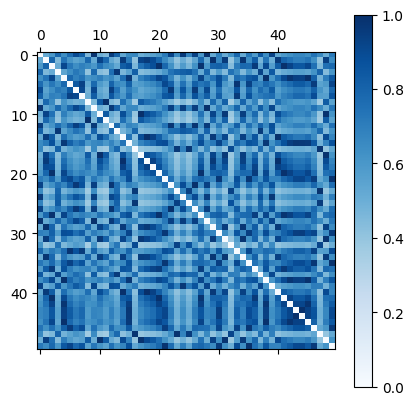

In [14]:
plt.matshow(sim_ci[:50,:50], cmap=plt.cm.Blues)
plt.colorbar()

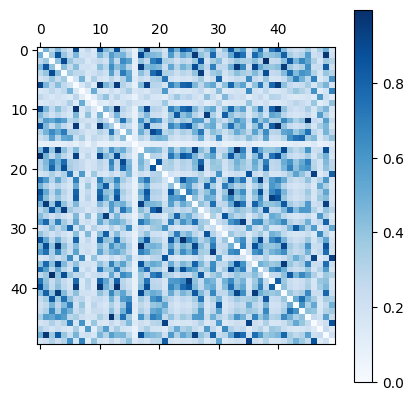

In [15]:
plt.matshow(sim_am[:50,:50], cmap=plt.cm.Blues)
plt.colorbar()

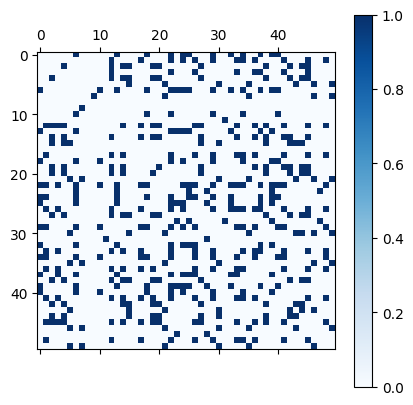

In [16]:
# Combine the two similarity matrices into an adjacency matrix
threshold = 0.5
sim_ci_cut = (sim_ci > threshold)
sim_am_cut = (sim_am > threshold)
sim = (sim_ci_cut & sim_am_cut).astype(int)
#sim_matrix = squareform(sim)
sim_matrix = sim
plt.matshow(sim_matrix[:50,:50], cmap=plt.cm.Blues)
plt.colorbar()

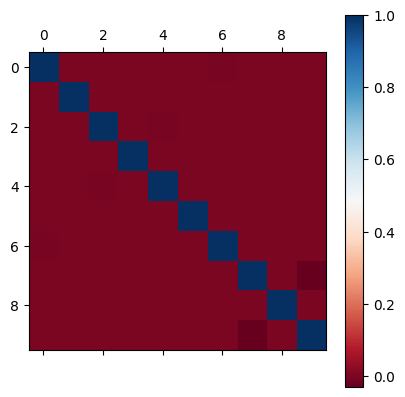

In [17]:
# Convert to sparse matrix
W = sparse.csr_matrix(sim_matrix)
assert(np.all(W.toarray().T == W.toarray()))

# Compute the Laplacian
d = np.array(np.sum(W, axis = 1))[:,0]
D = sparse.diags(d, format = "csr")
L = D - W

# Compute the symmetric normalized Laplacian
D_inv = scipy.linalg.pinv(D.toarray())
D_inv = sparse.csr_matrix(D_inv)
L_norm = sparse.csr_matrix.sqrt(D_inv) @ L @ sparse.csr_matrix.sqrt(D_inv)

# Plot the Laplacian
plt.matshow(L_norm.toarray()[:10,:10], cmap=plt.cm.RdBu)
plt.colorbar()

In [18]:
len(np.unique(L_norm.toarray()))

23518

## Spectral Clustering

In [19]:
evals, evecs = sparse.linalg.eigs(L_norm, k = 100, which = "SM")
eig = list(zip(evals.real, evecs.real.T))
evals, evecs = list(zip(*sorted(eig, key = lambda x: x[0])))
evecs = np.array(evecs).T

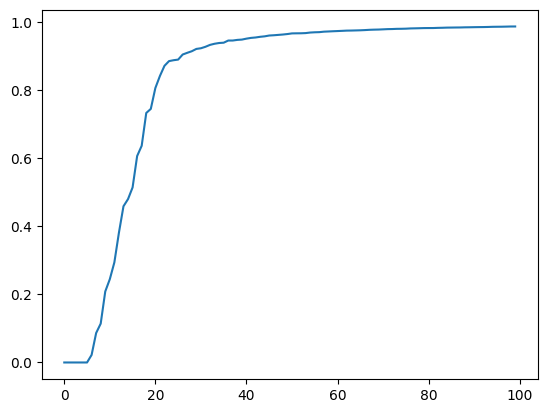

In [20]:
plt.plot(evals)

In [21]:
# KMeans (ok with (10, 30) with threshold=0.5 and n=1000)
n_c = 10
n_e = 30
kmeans = KMeans(n_clusters = n_c, random_state=42).fit(evecs[:, :n_e])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [22]:
# Plot clusters
def color_fn():
  color = "#%06x" % random.randint(0, 0xFFFFFF)
  yield color
color_dict = {str(c):color_fn().__next__() for c in np.unique(kmeans.labels_)}
colors = [color_dict[str(c)] for c in kmeans.labels_]
plot_stars(colors, 2)

In [23]:
# Visualize one eigenvector
points = np.asarray(stars[["x", "y", "z"]])
vec = evecs[:, 10]
inf = vec.min()
sup = vec.max()
colors = [cm.hot(x)[0:3] for x in (vec - inf)/(sup-inf)]
plot_stars(colors, 2)

In [24]:
%%capture
# Create table of stars
stars_table = pd.DataFrame(stars)
stars_table["type"] = "train"
stars_table["cluster"] = kmeans.labels_
idx = pd.DataFrame(stars_val).index
stars_table.loc[idx, "type"] = "val"

# Assign subtype depending on most frequent in the cluster
frequency = dict()
for j in range(n_c):
  cluster_stars = stars_table[stars_table["cluster"] == j]["subtype"]
  subtype = cluster_stars.value_counts().index[0]
  frequency[f"{j}"] = subtype

def pred_subtype(row):
  s = frequency[str(row.iloc[-1])]
  return s
val_set = stars_table[stars_table["type"]=="val"]
val_set["pred_subtype"] = val_set.apply(pred_subtype, axis = 1)

In [25]:
val_set.head()

,index,id,proper,dist,absmag,spect,ci,x,y,z,subtype,type,cluster,pred_subtype
10,36907,36907,NaN,209.2050,0.217,A0V,0.043,-50.002486,111.735921,-169.651311,0,val,5,0
23,8818,8818,NaN,104.8218,-0.712,M4III SB,1.597,63.693781,34.455513,-75.786103,4,val,1,0
30,89145,89146,NaN,119.6172,4.401,G0,0.617,5.191169,-79.036589,-89.635618,0,val,7,5
39,62115,62116,NaN,217.3913,-0.036,K0II/III,1.140,-123.355594,-25.148122,-177.228516,0,val,1,0
54,44363,44363,NaN,117.0960,3.387,G0,0.470,-4.586622,4.433852,116.922098,0,val,7,5


In [26]:
# Compute accuracy
true = val_set["subtype"].astype(float)
pred = val_set["pred_subtype"].astype(float)
print("Accuracy:", sum(true == pred)/val_set.shape[0]*100, "%")
print("Accuracy (at most 1):", sum(abs(true - pred)<2)/val_set.shape[0]*100, "%")
print("Accuracy (at most 2):", sum(abs(true - pred)<3)/val_set.shape[0]*100, "%")
print("Accuracy (at most 3):", sum(abs(true - pred)<4)/val_set.shape[0]*100, "%")
print("Accuracy (at most 4):", sum(abs(true - pred)<5)/val_set.shape[0]*100, "%")

Accuracy: 32.0 %
Accuracy (at most 1): 39.0 %
Accuracy (at most 2): 57.99999999999999 %
Accuracy (at most 3): 68.0 %
Accuracy (at most 4): 72.0 %


In [27]:
# Assign subtype depending on cluster membership


## Graph Neural Network (GNN)

## Evaluation

## Conclusion